In [1]:
import numpy as np
import pandas as pd
import time as time
import operator
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display, Image, clear_output
from scipy.spatial.distance import pdist, squareform
from collections import defaultdict

In [2]:
def find_closest( loc, whlist):
    dist = float('inf') * np.ones([nwhs,1], float)
    for wh in whlist:
        dist[wh] = np.linalg.norm(loc - whloc[wh], 2)
    return dist.argmin()

In [3]:
filepath = '/home/agarbuno/github-repos/hashcode-2016/qualif/data/busy_day.in'
f = open(filepath, "r+")

rows, cols, ndrones, deadline, maxload = np.array(f.readline().split(), np.int32)
ntypes = int(f.readline())
weights = np.array(f.readline().split(), np.int32)
nwhs = int(f.readline())

stocks = np.empty([nwhs, ntypes] , np.int32)
whloc  = np.empty([nwhs, 2], np.float32)

for wh in range(nwhs):
    whloc[wh]  = np.array(f.readline().split(), np.int32)
    stocks[wh] = np.array(f.readline().split(), np.int32)

norders = int(f.readline())
orders = defaultdict(list)
destinations = np.empty([norders, 2], np.int32)
nitemsorders = defaultdict(int)

for order in range(norders):
    destinations[order] = np.array(f.readline().split(), np.int32)
    nitemsorders[order] = int(f.readline())
    orders[order] = np.int_(f.readline().split())

f.close()

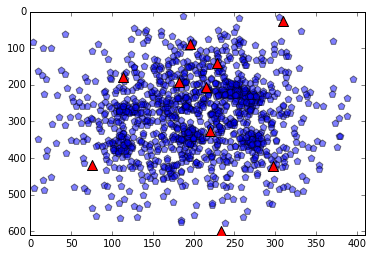

In [4]:
plt.scatter(destinations[:,0], destinations[:,1], marker='p', alpha = 0.5, s=50, zorder=10)
plt.scatter(whloc[:,0], whloc[:,1], marker='^', c = 'r', s=100, zorder=10)
plt.xlim(0, int(rows)+10)
plt.ylim(0, int(cols)+10)
plt.gca().invert_yaxis()

In [5]:
ndrones
drones = defaultdict(dict)
nidle = ndrones

for drone in range(ndrones):
    drones[drone] = dict()          #    Initialize drone
    drones[drone]['items'] = list() #    List of items in bag
    drones[drone]['cap'] = maxload  #    Available capacity
    drones[drone]['loc'] = whloc[0] #    Last known location
    drones[drone]['timec'] = 0      #    Time of completion calculated from previous issued order
    drones[drone]['idle'] = True    #    Is drone following waiting to be assigned?

In [6]:
# Histogram of number of most wanted items
items = defaultdict(int)

for order in orders:
    for item in orders[order]:
        items[item] += 1

In [7]:
# Rank orders by simplicity: small items first
r_orders = defaultdict(int)

for order in orders:
    for item in orders[order]:
        r_orders[order] += weights[item]

r_orders = np.array(r_orders.values(), np.double)
r_orders = 1/r_orders

In [8]:
r_orders = sorted(range(len(r_orders)), key=lambda k: -r_orders[k])

In [9]:
# Rank items by wanted level
items_index = defaultdict(list)
r_items = np.empty([ntypes,1], np.double)

for order in orders:
    for item in orders[order]:
        items_index[item].append(order)
        
for item in items_index:
    r_items[item] = len(items_index[item])
    
r_items = sorted(range(len(r_items)), key=lambda k: -r_items[k])

In [10]:
to_send = []

# For a particular order find the list of warehouses to send drones to pick items
# I am thinking in an order-oriented way, instead of item-oriented solution.
for item in orders[r_orders[0]]:
    to_send = np.where(stocks[:,item] > 0)
    wh = find_closest(drones[0]['loc'], to_send[0])
